In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.stem import WordNetLemmatizer # analyze meaning behind a word
import string # string processing
import pickle # save and load py objects 
import numpy as np # data structures
from nltk.corpus import stopwords # for extracting stop words
from nltk import pos_tag # for POS tagging
from nltk.corpus import wordnet # lexical database
import matplotlib.pyplot as plt # data visualization
import tensorflow as tf #tensorflow 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import eval
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,MaxPooling1D
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-product-reviews/Reviews.csv


In [2]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Functions
def get_pos(pos_tag):
    """Extract wordnet value corresponding to POS tag
    
    Keyword arguments:
    pos_tag : POS tag
    """
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    else:
        return wordnet.NOUN

def clean_review(review):
    """Data preprocessing
    
    Keyword arguments:
    review : A single product review
    """
    review = str(review)
    # convert to lowercase
    review = review.lower()
    # tokenize and strip punctuations
    review = [word.strip(string.punctuation) for word in review.split(' ')]
    # remove alphanumeric words
    review = [word for word in review if not any(char.isdigit() for char in word)]
    # remove stop words
    stop = stopwords.words('english')
    review = [x for x in review if x not in stop]
    review = [x for x in review if len(x) > 0]
    # POS tagging
    pos_tags = pos_tag(review)
    # lemmatize
    review = [WordNetLemmatizer().lemmatize(x[0], get_pos(x[1])) for x in pos_tags]
    review = [t for t in review if len(t) > 1]
    review = ' '.join(review)
    return review

**Amazaon Product Review Dataset**

In [4]:
# Import dataset
apr_raw_df = pd.read_csv('/kaggle/input/amazon-product-reviews/Reviews.csv')
apr_raw_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
apr_df = apr_raw_df.copy()
apr_df['review'] = apr_df['Summary'] + ' ' + apr_df['Text']
# Select relevant columns
apr_df['score'] = apr_df['Score']
apr_df = apr_df[['review', 'score']]
apr_df.head(10)

,review,score
0,Good Quality Dog Food I have bought several of...,5
1,Not as Advertised Product arrived labeled as J...,1
2,"""Delight"" says it all This is a confection tha...",4
3,Cough Medicine If you are looking for the secr...,2
4,Great taffy Great taffy at a great price. The...,5
5,Nice Taffy I got a wild hair for taffy and ord...,4
6,Great! Just as good as the expensive brands! ...,5
7,"Wonderful, tasty taffy This taffy is so good. ...",5
8,Yay Barley Right now I'm mostly just sprouting...,5
9,Healthy Dog Food This is a very healthy dog fo...,5


In [6]:
# Apply data preprocessing measures
apr_df['review'] = apr_df['review'].apply(lambda x: clean_review(x))
apr_df.head(10)

,review,score
0,good quality dog food buy several vitality can...,5
1,advertised product arrive labeled jumbo salt p...,1
2,delight say confection around century light pi...,4
3,cough medicine look secret ingredient robituss...,2
4,great taffy great taffy great price wide assor...,5
5,nice taffy get wild hair taffy order five poun...,4
6,great good expensive brand saltwater taffy gre...,5
7,wonderful tasty taffy taffy good soft chewy fl...,5
8,yay barley right i'm mostly sprout cat eat gra...,5
9,healthy dog food healthy dog food good digesti...,5


In [7]:
# Generate labels
apr_median_score = np.median(np.sort(apr_df['score'].unique()))
apr_df['label'] = apr_df['score'].apply(lambda x: 'negative' if x < apr_median_score 
                                        else('neutral' if x == apr_median_score else 'positive'))
apr_df.head(10)

,review,score,label
0,good quality dog food buy several vitality can...,5,positive
1,advertised product arrive labeled jumbo salt p...,1,negative
2,delight say confection around century light pi...,4,positive
3,cough medicine look secret ingredient robituss...,2,negative
4,great taffy great taffy great price wide assor...,5,positive
5,nice taffy get wild hair taffy order five poun...,4,positive
6,great good expensive brand saltwater taffy gre...,5,positive
7,wonderful tasty taffy taffy good soft chewy fl...,5,positive
8,yay barley right i'm mostly sprout cat eat gra...,5,positive
9,healthy dog food healthy dog food good digesti...,5,positive


In [8]:
sentences = apr_df['review']
labels = apr_df['label']

In [9]:
#Create Tokenizer to tokenize and produce a bag of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [10]:
text_sequences = np.array(tokenizer.texts_to_sequences(sentences))
sequence_dict = tokenizer.word_index
word_dict = dict((num, val) for (val, num) in sequence_dict.items())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [11]:
# Map word to numeric code for feeding in training
review_cleans = [doc.split(' ') for doc in sentences]
reviews_encoded = [];
for i,review in enumerate(review_cleans):
    reviews_encoded.append([sequence_dict[x] for x in review if x !='' and x in sequence_dict])

(array([2.0000e+00, 3.3000e+01, 2.0000e+00, 0.0000e+00, 8.0000e+00,
        4.0000e+01, 2.2600e+02, 8.9100e+02, 1.9020e+03, 4.1810e+03,
        6.8750e+03, 9.9610e+03, 1.3062e+04, 1.5124e+04, 1.7015e+04,
        1.7622e+04, 1.7746e+04, 1.7495e+04, 1.6392e+04, 1.6271e+04,
        1.5039e+04, 1.4854e+04, 1.3975e+04, 2.6454e+04]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

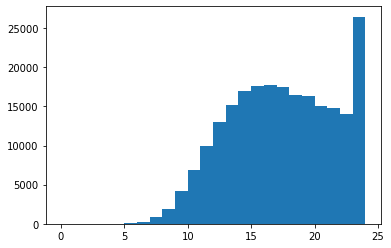

In [12]:
lengths = [len(x) for x in reviews_encoded]
plt.hist(lengths, bins=range(25))

In [13]:
lable_encode = {'negative': [0,0,1] , 'neutral': [0,1,0],'positive':[1,0,0]}
max_cap =10;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')
Y = np.array([lable_encode[label] for label in labels])

In [14]:
# Adding code to reproduce the training
np.random.seed(1024);
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

In [15]:
# Spritting data into train, test, eval
X = X[random_posits]
Y = Y[random_posits]
train_perc = int(0.85 * len(X))
val_perc = int(0.93 * len(X))
X_train, Y_train = X[:train_perc], Y[:train_perc]
X_val, Y_val = X[train_perc:val_perc], Y[train_perc:val_perc]
X_test, Y_test = X[val_perc:], Y[val_perc:]

In [16]:
# Create Model
model = Sequential();
model.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap));
#adding a LSTM layer of dim 1--
model.add(LSTM(200, return_sequences=True));
model.add(LSTM(200, return_sequences=False));
#adding a dense layer with activation function of relu
model.add(Dense(100, activation='relu',kernel_initializer='uniform'));#best 50,relu
#adding the final output activation with activation function of softmax
model.add(Dense(3, activation='softmax', kernel_initializer='uniform'));
print(model.summary());

2022-01-22 04:15:48.894267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 04:15:49.039182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 04:15:49.039990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 04:15:49.041309: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 10)            1119340   
_________________________________________________________________
lstm (LSTM)                  (None, 10, 200)           168800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 1,629,343
Trainable params: 1,629,343
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
#Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Fit the model and train for 5 epochs, save this history for plot
history = model.fit(X_train, Y_train, batch_size=16, epochs=5, validation_data=(X_val, Y_val))

Epoch 1/5


2022-01-22 04:15:51.740678: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-22 04:15:54.724079: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


30200/30200 [==============================] - 196s 6ms/step - loss: 0.4079 - accuracy: 0.8543 - val_loss: 0.3737 - val_accuracy: 0.8661
Epoch 2/5
30200/30200 [==============================] - 192s 6ms/step - loss: 0.3510 - accuracy: 0.8737 - val_loss: 0.3606 - val_accuracy: 0.8712
Epoch 3/5
30200/30200 [==============================] - 192s 6ms/step - loss: 0.3193 - accuracy: 0.8863 - val_loss: 0.3533 - val_accuracy: 0.8755
Epoch 4/5
30200/30200 [==============================] - 193s 6ms/step - loss: 0.2932 - accuracy: 0.8967 - val_loss: 0.3433 - val_accuracy: 0.8793
Epoch 5/5
30200/30200 [==============================] - 193s 6ms/step - loss: 0.2703 - accuracy: 0.9053 - val_loss: 0.3412 - val_accuracy: 0.8801


In [19]:
score = model.evaluate(X_test, Y_test)
print("Test accuracy: %0.4f%%" % (score[1]*100))

1244/1244 [==============================] - 4s 3ms/step - loss: 0.3401 - accuracy: 0.8814
Test accuracy: 88.1408%


In [20]:
# Save the model
model.save('./my_model')

2022-01-22 04:32:06.346758: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


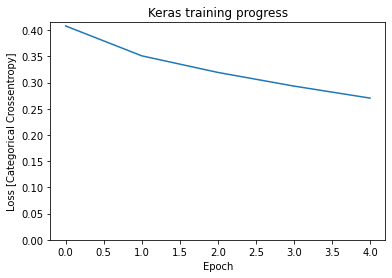

In [21]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Categorical Crossentropy]')
plt.title('Keras training progress');